In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
print(os.listdir("../input"))
#print(os.listdir("../input/xception-weights/"))
print(os.listdir("../input/aptos2019-blindness-detection/"))

# Any results you write to the current directory are saved as output.

['aptos2019-blindness-detection', 'xception']
['train.csv', 'train_images', 'test_images', 'test.csv', 'sample_submission.csv']


In [2]:
train_csv = '../input/aptos2019-blindness-detection/train.csv'
image_dataset = '../input/aptos2019-blindness-detection/train_images'
sample_csv = '../input/aptos2019-blindness-detection/sample_submission.csv'
test_dataset = '../input/aptos2019-blindness-detection/test_images'

xception_weights = '../input/Xception/xception_weights_tf_dim_ordering_tf_kernels_notop.h5'
import tensorflow as tf


/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

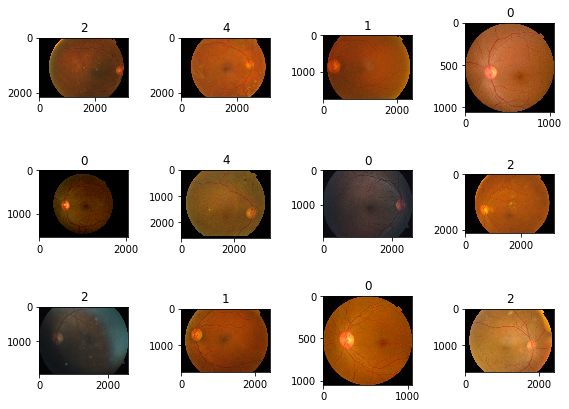

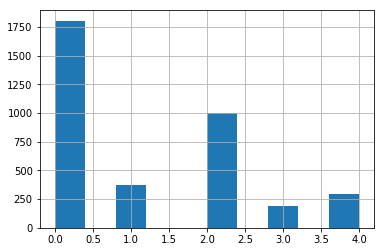

In [3]:
import cv2
import numpy
import csv
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import os

def display_images_sample(df,columns=4,rows=3):
    fig = plt.figure(figsize=(2*columns,2*rows))

    for i in range(columns*rows):
        image_name = df.loc[i,'id_code']
        image_id  = df.loc[i,'diagnosis']
        image_path = os.path.join(image_dataset,image_name)
        image_path = image_path + '.png'
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        fig.add_subplot(rows,columns,i+1)
        plt.title(image_id)
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

def data_dist(df_train):
    x = df_train['id_code']
    y = df_train['diagnosis']
    x,y = shuffle(x,y,random_state = 8)
    y.hist()
    plt.show()

df_train = pd.read_csv(train_csv)
display_images_sample(df_train)
data_dist(df_train)

In [4]:
def cohens_kappa(y_true, y_pred):
    y_true_classes = tf.argmax(y_true, 1)
    y_pred_classes = tf.argmax(y_pred, 1)
    return tf.contrib.metrics.cohen_kappa(y_true_classes, y_pred_classes, 5)[1]

In [5]:
'''
model
ResNet
'''

import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.backend import clear_session
from tensorflow.keras.models import Model , load_model
from tensorflow.keras.layers import Dense , Input , Flatten , Dropout ,BatchNormalization
from tensorflow.keras.applications import ResNet50 
from tensorflow.keras.applications import Xception

img = Input(shape=(224,224,3))

base_model = Xception(include_top = False,
                        weights='imagenet',
                        input_tensor=img,
                        pooling='avg',
                        input_shape = None)
# base_model = ResNet50(include_top = False,
#                      weights = resnet_weights,
#                      input_tensor = img,
#                      pooling = 'avg',
#                      input_shape = None)

final_layer = base_model.layers[-1].output
final_layer = Dropout(0.2)(final_layer)
dense_layer1 = Dense(512, activation='relu')(final_layer)
dense_layer1 = Dropout(0.3)(dense_layer1)
# dense_layer1 = BatchNormalization()(dense_layer1)
dense_layer2 = Dense(128,activation= 'relu')(dense_layer1)
dense_layer2 = Dropout(0.3)(dense_layer2)
output_layer = Dense(5,activation='softmax')(dense_layer2)

model = Model(img,output_layer)
for layer in base_model.layers:
  layer.trainable = True

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary() 

83689472/83683744 [==============================] - 4s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 111, 111, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 111, 111, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 111, 111, 32) 0           block1_conv1_bn[0][0]            
_____________________________

In [6]:
import numpy as np

In [7]:
size = 224,224
def get_cropped_image(image):
    img = cv2.blur(image,(2,2))
    slice1Copy = np.uint8(img)
    canny = cv2.Canny(slice1Copy, 0, 50)
    pts = np.argwhere(canny>0)
    y1,x1 = pts.min(axis=0)
    y2,x2 = pts.max(axis=0)
    cropped_img = img[y1:y2, x1:x2]
    cropped_img = cv2.resize(cropped_img, size)
    cropped_img = cropped_img.astype("float32")*(1.)/255
    return np.array(cropped_img)

In [8]:
#image preprocessing Ben's preprocessing
def crop_image_from_gray(img, tol=7):
    """
    Applies masks to the orignal image and 
    returns the a preprocessed image with 
    3 channels
    """
    # If for some reason we only have two channels
    if img.ndim == 2:
        mask = img > tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    # If we have a normal RGB images
    elif img.ndim == 3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img > tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img
    
def preprocess_image(image, sigmaX=10):
    """
    The whole preprocessing pipeline:
    1. Read in image
    2. Apply masks
    3. Resize image to desired size
    4. Add Gaussian noise to increase Robustness
    """
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_image_from_gray(image)
    image = cv2.resize(image, (224, 224))
    image = cv2.addWeighted (image,4, cv2.GaussianBlur(image, (0,0) ,sigmaX), -4, 128)
    return image

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              min_delta=0.0004,
                              patience=5,
                              factor=0.5,
                              min_lr=1e-6,
                              mode='auto',
                              verbose=1)

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss',
                           min_delta=0.0001, 
                           patience=10, 
                           verbose=1,
                           mode='auto')

In [11]:
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam 
#load train and test data
df_train = pd.read_csv(train_csv)
df_train["id_code"] = df_train["id_code"].apply(lambda x:x+".png")
df_train["diagnosis"] = df_train['diagnosis'].astype('str')


train_datagen = ImageDataGenerator(rescale = 1/255.,
                                  horizontal_flip = True,
                                  vertical_flip = False,
                                  width_shift_range = 0.1,
                                  height_shift_range = 0.1,
                                  fill_mode = 'nearest',
                                  validation_split = 0.15,
                                  zoom_range = 0.2,
                                  preprocessing_function=preprocess_image,
                                  rotation_range = 10)
      
train_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    directory = image_dataset,
    validation_split = 0.2,
    x_col = 'id_code',
    y_col = 'diagnosis',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 64,
    shaffle=True,
    subset = 'training'
)

val_generator = train_datagen.flow_from_dataframe(
    dataframe = df_train,
    x_col = 'id_code',
    y_col = 'diagnosis',
    directory = image_dataset,
    class_mode = "categorical",
    batch_size = 64,
    shaffle=True,
    target_size = (224,224),
    subset = "validation"
    )
optimizer = Adam(lr=0.0005)
save_callback = ModelCheckpoint(filepath='Blindness-detection.h5', monitor='val_loss', save_best_only=True)
model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])


history = model.fit_generator(
    train_generator,
    epochs = 30,
    steps_per_epoch = 20,
    validation_data = val_generator,
    validation_steps = 7,
    callbacks = [reduce_lr,early_stop,save_callback]
)
model.save('xceptionnew.h5')

Found 3113 validated image filenames belonging to 5 classes.
Found 549 validated image filenames belonging to 5 classes.
Epoch 1/30
20/20 [==============================] - 281s 14s/step - loss: 1.0557 - acc: 0.6165 - val_loss: 21.2173 - val_acc: 0.4710
Epoch 2/30
20/20 [==============================] - 174s 9s/step - loss: 0.7842 - acc: 0.7266 - val_loss: 63.5187 - val_acc: 0.4554
Epoch 3/30
20/20 [==============================] - 193s 10s/step - loss: 0.7386 - acc: 0.7312 - val_loss: 30.7337 - val_acc: 0.4688
Epoch 4/30
20/20 [==============================] - 190s 9s/step - loss: 0.6289 - acc: 0.7796 - val_loss: 4.5458 - val_acc: 0.5871
Epoch 5/30
20/20 [==============================] - 192s 10s/step - loss: 0.6359 - acc: 0.7516 - val_loss: 3.4851 - val_acc: 0.5737
Epoch 6/30
20/20 [==============================] - 192s 10s/step - loss: 0.5613 - acc: 0.7883 - val_loss: 1.1393 - val_acc: 0.7455
Epoch 7/30
20/20 [==============================] - 183s 9s/step - loss: 0.5815 - acc:

kappa loss <tensorflow.python.keras.callbacks.History object at 0x7facb021aba8>


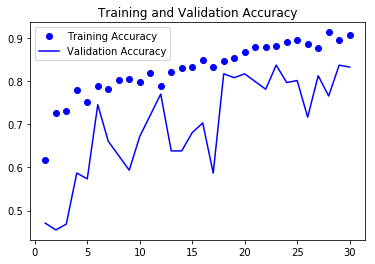

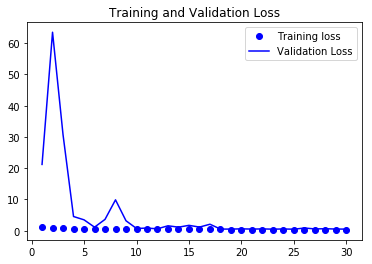

In [12]:
#plotting accuracies and losses
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
print('kappa loss',history)

epochs = range(1,len(acc) + 1)

plt.plot(epochs,acc,'bo',label = 'Training Accuracy')
plt.plot(epochs,val_acc,'b',label = 'Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(epochs,loss,'bo',label = 'Training loss')
plt.plot(epochs,val_loss,'b',label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

In [13]:
#make predictions on test images

test_datagen = ImageDataGenerator(rescale=1./255,
                                 preprocessing_function=preprocess_image)


sample_df = pd.read_csv(sample_csv)

sample_df["id_code"]=sample_df["id_code"].apply(lambda x:x+".png")

test_generator = test_datagen.flow_from_dataframe(  
        dataframe=sample_df,
        directory = test_dataset,    
        x_col="id_code",
        target_size = (224,224),
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )
preds = model.predict_generator(
    test_generator,
    steps=len(test_generator.filenames)
)


Found 1928 validated image filenames.


In [14]:
#sklearn confusion matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
y_true = val_generator.classes
y_pred = np.argmax(model.predict_generator(val_generator),axis=1)
print(confusion_matrix(y_true,y_pred))

#classification report
target_names = ['0','1','2','3','4']
print(classification_report(val_generator.classes, y_pred, target_names=target_names))

[[115  31  82   5  19]
 [ 20  10  21   0   5]
 [ 82  20  48   5   9]
 [ 14   3   9   0   3]
 [ 21   7  14   1   5]]
              precision    recall  f1-score   support

           0       0.46      0.46      0.46       252
           1       0.14      0.18      0.16        56
           2       0.28      0.29      0.28       164
           3       0.00      0.00      0.00        29
           4       0.12      0.10      0.11        48

    accuracy                           0.32       549
   macro avg       0.20      0.21      0.20       549
weighted avg       0.32      0.32      0.32       549



In [15]:
# #submission formatting
filenames= test_generator.filenames
results=pd.DataFrame({"id_code":filenames,
                      "diagnosis":np.argmax(preds,axis = 1)})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv("submission.csv",index=False)

Text(0.5, 1.0, 'Test Samples Per Class')

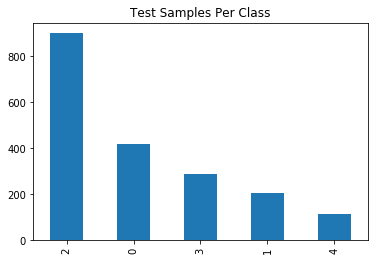

In [16]:
results['diagnosis'].value_counts().plot(kind='bar')
plt.title('Test Samples Per Class')